In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest

In [2]:
df = pd.read_csv("nyc_taxi_trip_duration.csv", usecols=["dropoff_datetime"], engine='pyarrow')
df["dropoff_datetime"] = df["dropoff_datetime"].dt.round('D')
df["trip_count"] = 1
df = df.groupby(by=['dropoff_datetime']).sum().sort_index().reset_index()

In [3]:
df['Day'] = df['dropoff_datetime'].dt.weekday
df['Month_day'] = df['dropoff_datetime'].dt.day

In [4]:
df = df.set_index("dropoff_datetime")

In [5]:
def run_isolation_forest(dataframe: pd.DataFrame, contamination="auto", n_estimators=200) -> pd.DataFrame:
    IF = (IsolationForest(random_state=0,
                          contamination=contamination,
                          n_estimators=n_estimators)
         )
    
    IF.fit(dataframe)
    output = IF.predict(dataframe)
    output[output == 1] = 0
    output[output == -1] = 1
    
    score = IF.decision_function(dataframe)
    return output, score

In [6]:
outliers, score = run_isolation_forest(df, contamination=0.15)

c:\users\aidors\pycharmprojects\pd_pr\venv\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [7]:
predictions = df.assign(Outliers=outliers).assign(Score=score).reset_index()

<Axes: xlabel='dropoff_datetime', ylabel='trip_count'>

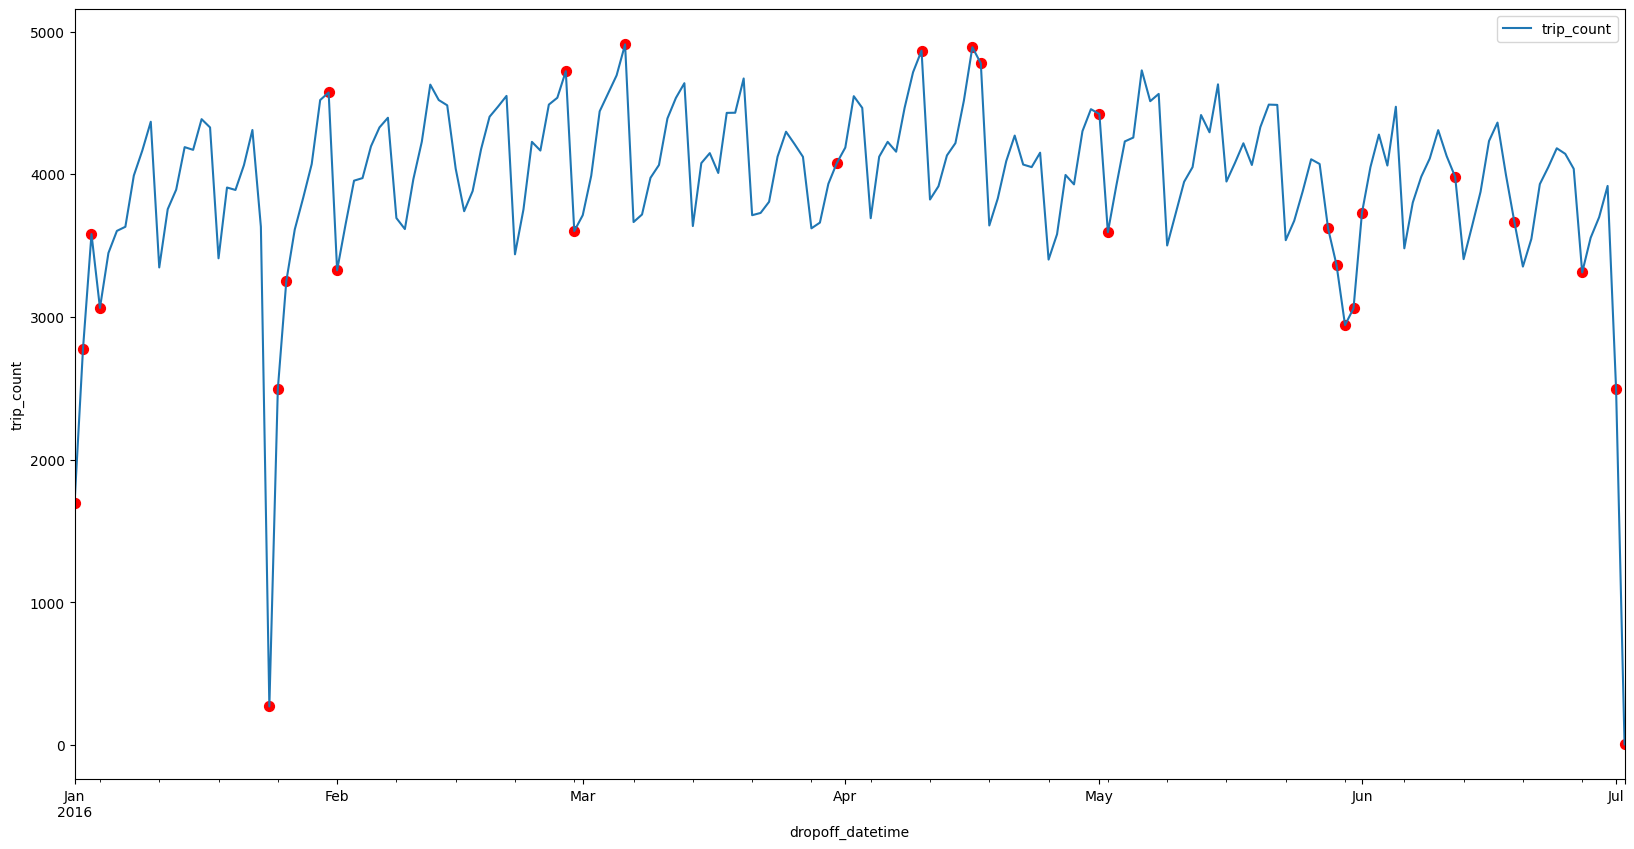

In [8]:
ax = predictions.plot(x="dropoff_datetime", y="trip_count", figsize=(20, 10))
predictions.loc[predictions['Outliers'] == 1].plot.scatter(x="dropoff_datetime", y="trip_count", ax=ax, c='r', s=50)